## Step 5: Evaluate the derivation of the epigenetic memory astrocyte up- and down-signature gene sets

Now we further evaluate how the up- and down-signatures were derived using the two-hit versus one-hit cytokine stimulation RNA-seq differential expression test results in Lee et al's Supplementary Table 1.

In [1]:
library(ggplot2)
library(dplyr)
library(readxl)
library(ggpubr)
setwd('..') # changing the working directory to the 'EpiMemAstros' folder. Adjust as needed.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




First, read in the gene signatures from Supplementary Table 3. 

This table includes the same differential expression statistics from Supplementary Table 1 (e.g. log2FoldChange, p-value, etc), however this table only includes those genes which the authors included in the epigenetic memory astrocyte gene signatures (Up-Signature & Down-Signature).

Per communication with the authors, all genes in this table with log2FoldChange > 0 are a component of the Up-signature, and all genes with a log2FoldChange < 0 are a component of the Down-signature.

In [2]:
signature = read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM4_ESM.xlsx')
up_genes = signature %>% filter(log2FoldChange > 0) %>% .$gene
down_genes = signature %>% filter(log2FoldChange < 0) %>% .$gene

While Lee et al's Extended Data Figure 3 indicates that 1,105 genes comprise the Up-Signature and 1,110 genes comprise the Down-Signature, this may be a typo – we note Supplementary Table 3 lists only 1,011 genes are in the Down-signature:

In [3]:
print(paste0('Up-signature includes ', length(up_genes), ' genes.'))
print(paste0('Down-signature includes ', length(down_genes), ' genes.'))

[1] "Up-signature includes 1105 genes."
[1] "Down-signature includes 1011 genes."


Next, read in the differential expression test results from Supplementary Table 1.

In [4]:
de_results <- read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM2_ESM.xlsx')

Add the ranking score metric used by Lee et al (-log10(adjusted p-value) * log2foldchange) and sort the genes by score.

In [5]:
score_df <- de_results %>% mutate(score = -1*log10(padj)*log2FoldChange) %>% arrange(desc(score))

Now that the data frame is sorted, we'll add a gene index rank based on sorted score, and add whether each gene was listed in the Up-Signature or Down-Signature gene sets.

In [6]:
score_df$index <- 1:nrow(score_df)
score_df <- score_df %>% mutate(set = ifelse(Gene %in% up_genes, 'Up-signature', ifelse(Gene %in% down_genes, 'Down-signature', "Neither")))
score_df$set <- factor(score_df$set, levels = c('Neither', 'Down-signature', 'Up-signature'))
score_df = score_df[order(score_df$set, abs(score_df$score)),]

Our data frame now includes a sorted index and score for each gene. We next attempt to recreate the plot from Lee et al's Extended Data Figure 3a to demonstrate the derivation of the epigenetic memory astrocyte gene signatures:

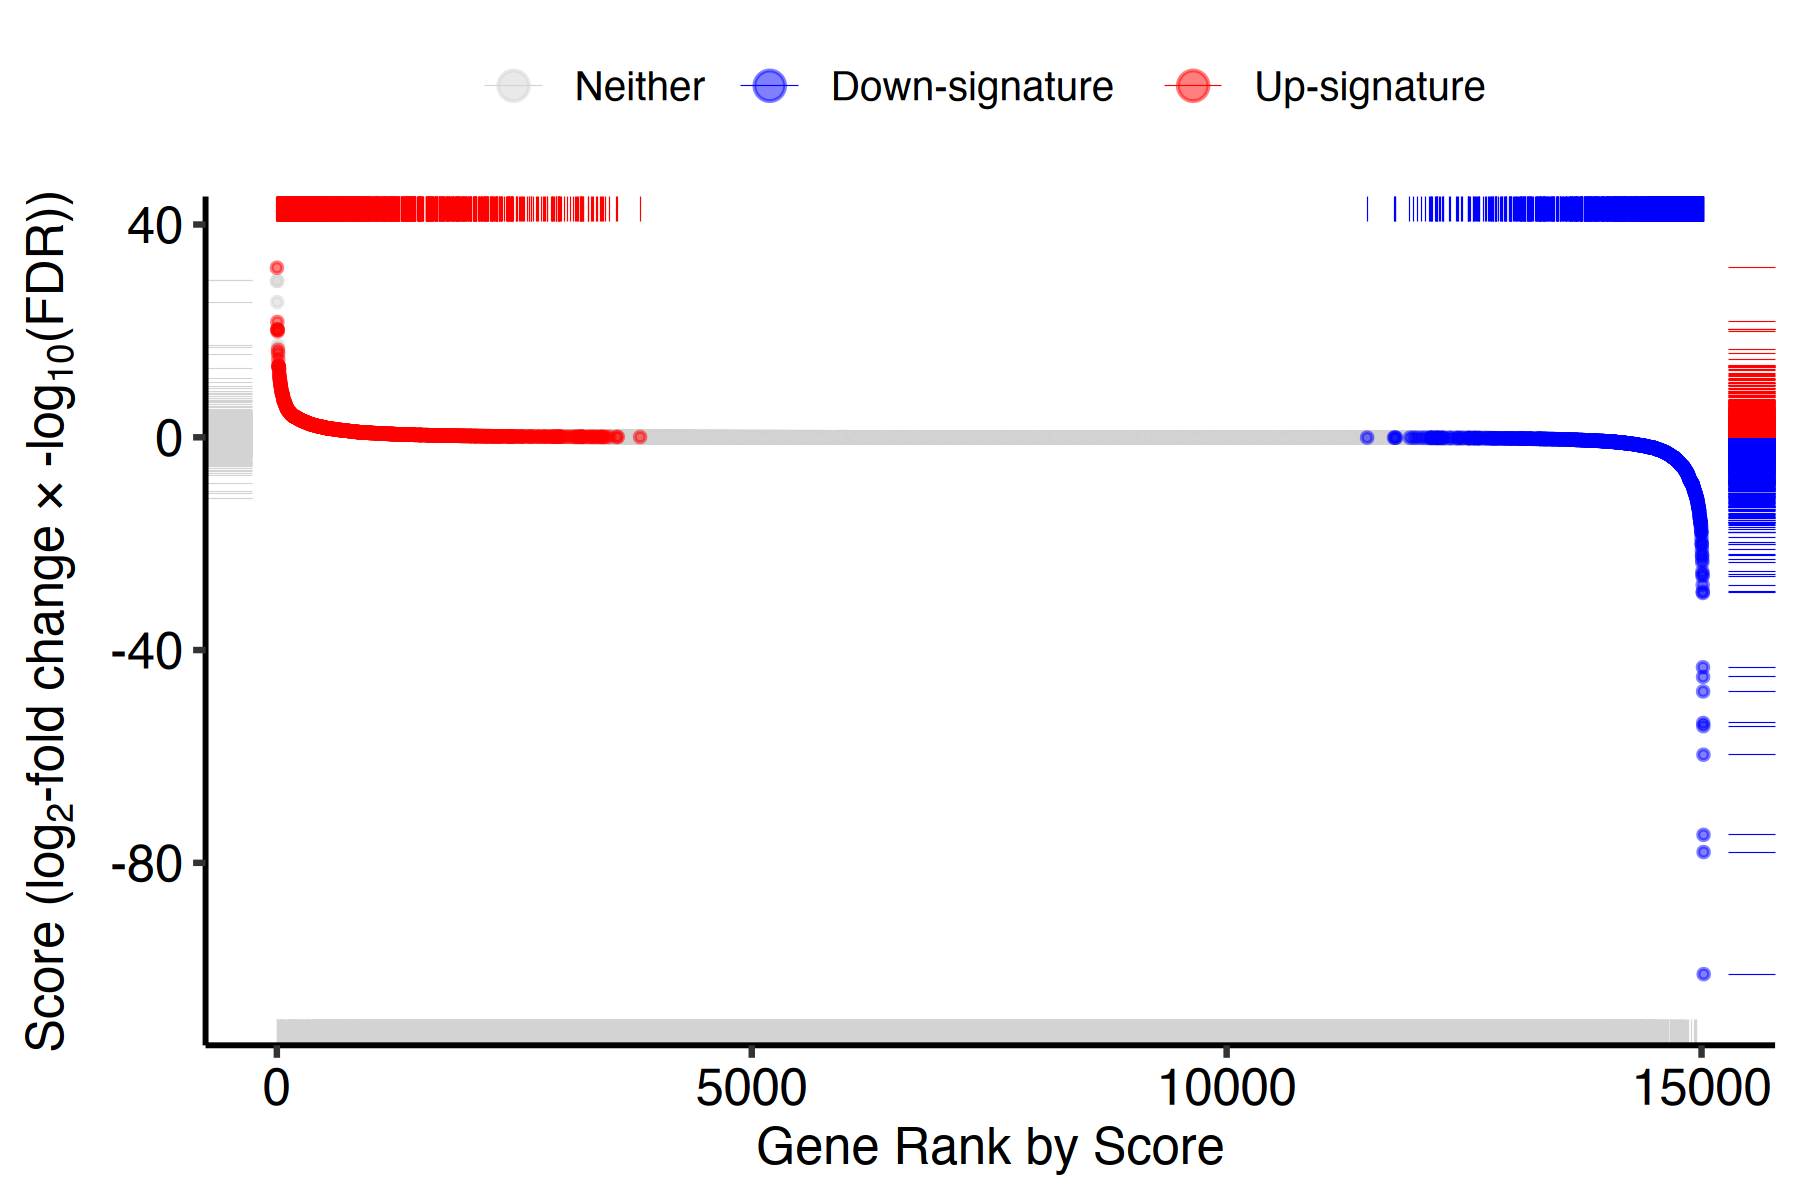

In [7]:
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res = 300)

image = ggplot(score_df, aes(x = index, y = score, color = set)) + 
    geom_point(size = 0.75, alpha = 0.5) +
    scale_y_continuous(expand = c(0.1, 0.1)) + 
    geom_rug(data=subset(score_df,set=="Down-signature"),aes(x=index, y = score), linewidth = 0.1, sides = 'tr', position = "jitter") + 
    geom_rug(data=subset(score_df,set=="Up-signature"),aes(x=index, y = score), linewidth = 0.1, sides = 'tr', position = "jitter") + 
    geom_rug(data=subset(score_df,set=="Neither"),aes(x=index, y = score), linewidth = 0.1, alpha = 1, sides = 'bl', position = "jitter") + 
    labs(x = "Gene Rank by Score", y = expression(paste("Score (",log[2],"-fold change \u00D7 -",log[10],"(FDR))", sep = "")), color = NULL) + 
    scale_color_manual(values = c("lightgray", "blue", "red")) + theme_pubr() + 
    guides(color = guide_legend(override.aes = list(size=3)))

ggsave(file="outputs/figures/figure1d.svg", plot=image, width=6, height=4, dpi = 600)

image

We note a few discrepancies between this plot and that of Extended Data Figure 3A:

1. The up- and down- signature genes appear to extend far beyond the respective elbow and knee points as shown in the original figure.
2. The up- and down- signature genes exclude some genes with more extreme scores (either more positive or more negative) and include some genes with less extreme scores (less positive, less negative) than would be included if genes were partitioned into the gene sets by score alone.
3. The up- and down- signature gene sets include many genes with scores close to zero, likely including many genes which were not differentially expressed between conditions. (We will explore this below.)
4. The x-axis (gene index when ranked by score) includes many more values than in the original figure panel.

The explanation for these discrepancies is unclear.

Given discrepancy #3 above, we now examine the distribution of adjusted p-values for the differential expression test results for genes in the Up- and Down-signatures. 

First, we examine the Up-Signature:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


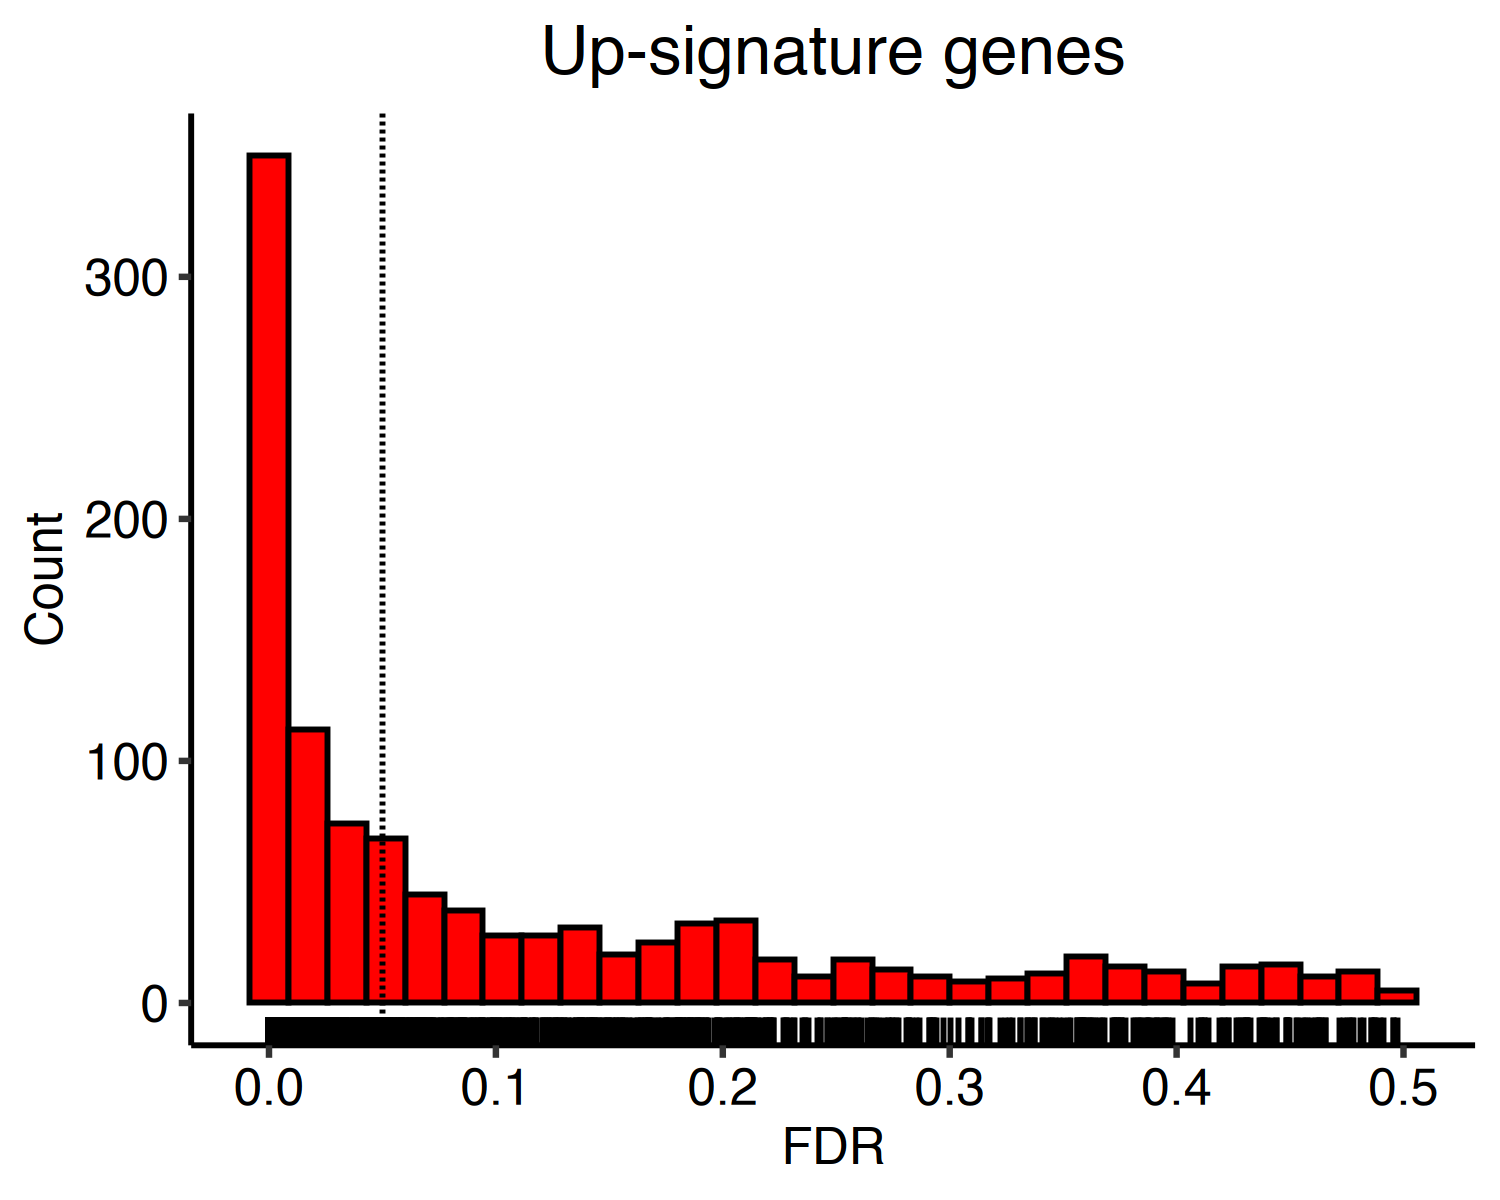

In [8]:
options(repr.plot.width=5, repr.plot.height=4, repr.plot.res = 300)

image = ggplot(signature %>% filter(log2FoldChange > 0), aes(x = padj)) + 
    geom_histogram(color = 'black', fill = 'red') + 
    geom_vline(xintercept = 0.05, linetype = 'dashed') + 
    labs(x = "FDR", y = "Count", title = "Up-signature genes") + 
    geom_rug() + theme_pubr() + 
    theme(plot.title=element_text(hjust = 0.5, face="bold", size = 16))

ggsave(file="outputs/figures/figure1e_upsignature.svg", plot=image, width=5, height=4, dpi = 600)

image

Next, we examine the Down-Signature:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


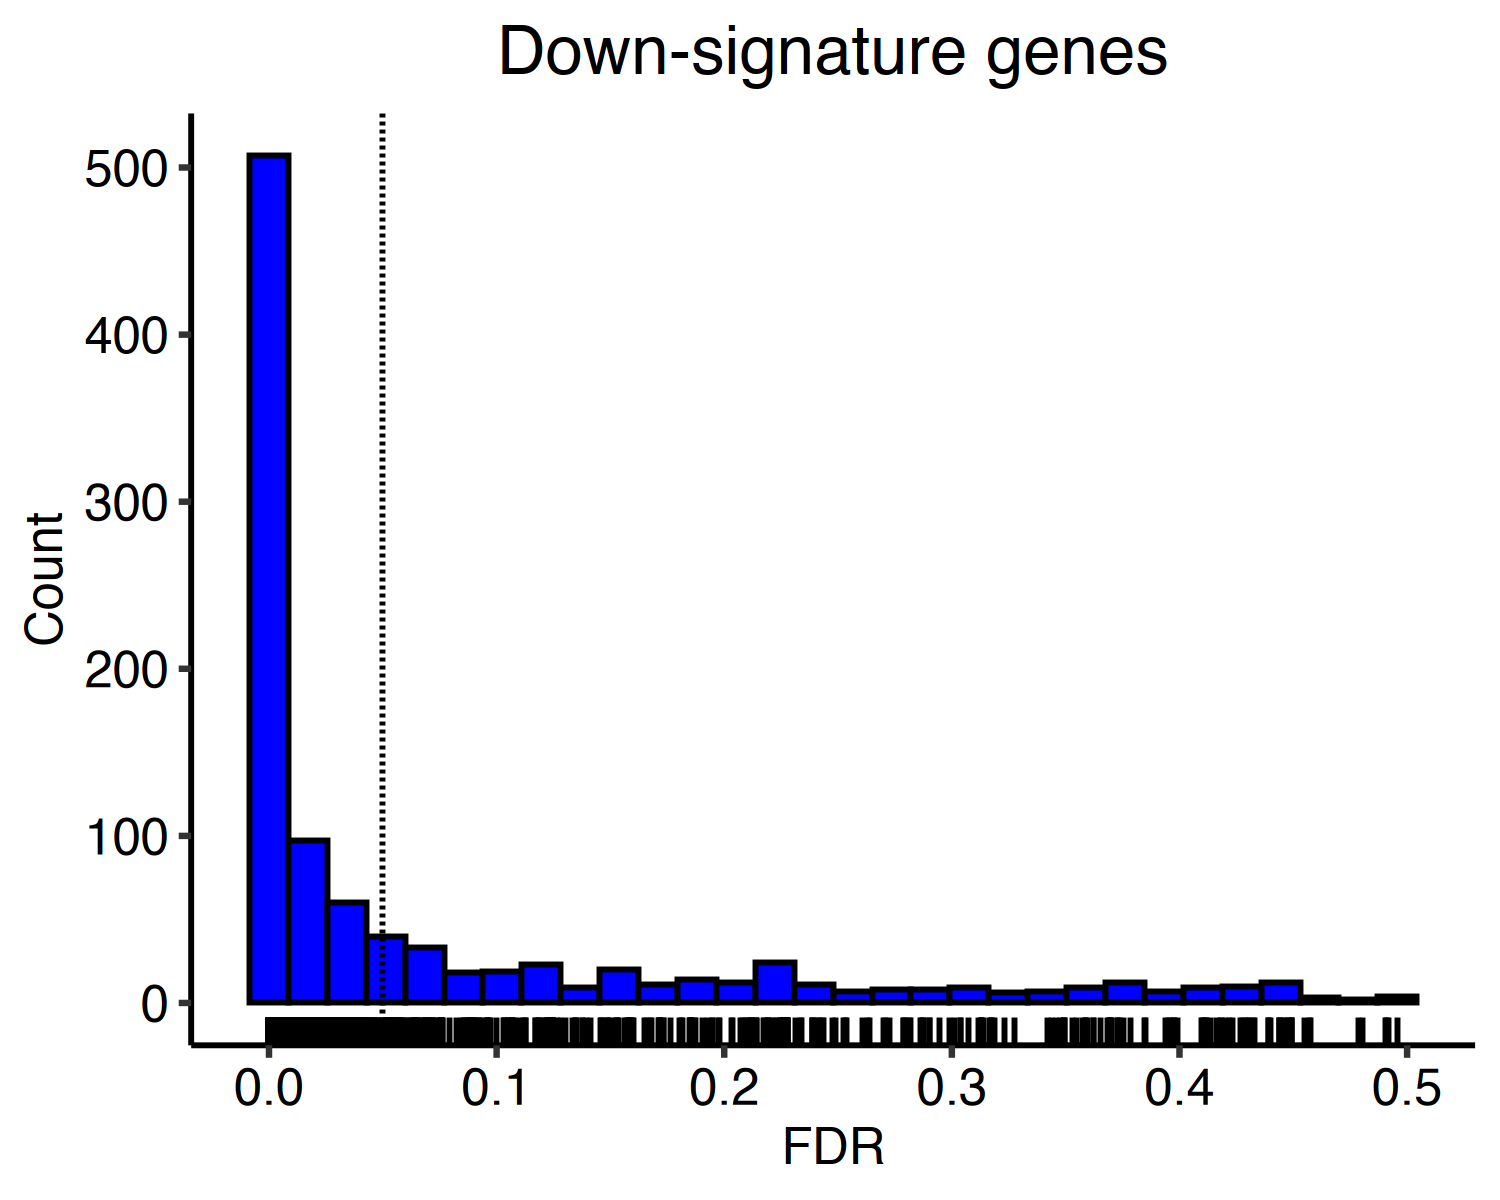

In [9]:
options(repr.plot.width=5, repr.plot.height=4, repr.plot.res = 300)

image = ggplot(signature %>% filter(log2FoldChange < 0), aes(x = padj)) + 
    geom_histogram(color = 'black', fill = 'blue') + 
    geom_vline(xintercept = 0.05, linetype = 'dashed') + 
    labs(x = "FDR", y = "Count", title = "Down-signature genes") + 
    geom_rug() + theme_pubr() + 
    theme(plot.title=element_text(hjust = 0.5, face="bold", size = 16))

ggsave(file="outputs/figures/figure1e_downsignature.svg", plot=image, width=5, height=4, dpi = 600)

image

It appears both signatures include a large number of genes with non-significant adjusted p-values (> 0.05). Let's check how many genes in the signatures had non-significnat p-values.

For the Up-Signature:

In [10]:
up_p_df = data.frame('number'=c(signature %>% filter(log2FoldChange > 0) %>% filter(padj < 0.05) %>% nrow(.),
             signature %>% filter(log2FoldChange > 0) %>% filter(padj >= 0.05) %>% nrow(.)),
           'percent'=c(signature %>% filter(log2FoldChange > 0) %>% filter(padj < 0.05) %>% nrow(.)/signature %>% filter(log2FoldChange > 0) %>% nrow(.),
             signature %>% filter(log2FoldChange > 0) %>% filter(padj >= 0.05) %>% nrow(.)/signature %>% filter(log2FoldChange > 0) %>% nrow(.)),
               'FDR'=c('p<0.05', 'p≥0.05'))

up_p_df

number,percent,FDR
<int>,<dbl>,<chr>
572,0.5176471,p<0.05
533,0.4823529,p≥0.05


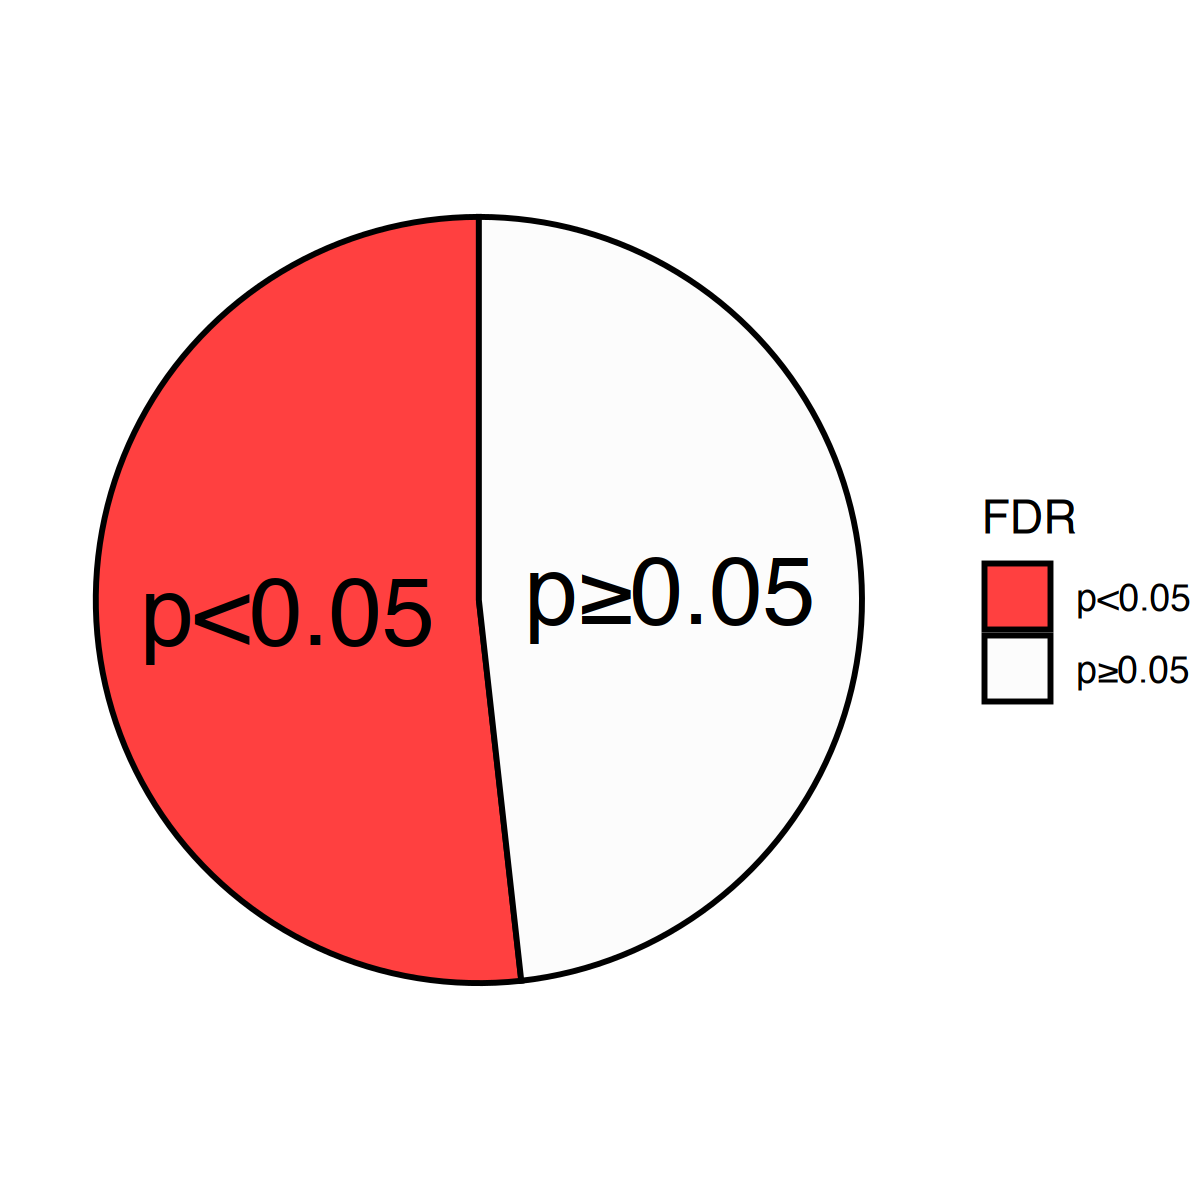

In [11]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res = 300, warn = -1)

image = ggplot(up_p_df, aes(x = "", y = percent, fill = FDR, labels = FDR)) +
  geom_col(color = "black") +
  geom_text(aes(label = FDR), color = c("black", "black"),
            position = position_stack(vjust = 0.5),size = 8,
            show.legend = FALSE) +
  guides(fill = NULL, labels = NULL) +
  scale_fill_manual(values = c("brown1", "gray99")) +
  coord_polar(theta = "y") + theme_void()

ggsave(file="outputs/figures/figure1e_upsignature_inset.svg", plot=image, width=4, height=4, dpi = 600)

image

options(warn=0)

It appears 533 out of 1,105 genes in the Up-Signature had an adjusted p-value > 0.05 (48.2% of the gene set).

For the Down-Signature:

In [12]:
down_p_df = data.frame('number'=c(signature %>% filter(log2FoldChange < 0) %>% filter(padj < 0.05) %>% nrow(.),
             signature %>% filter(log2FoldChange < 0) %>% filter(padj >= 0.05) %>% nrow(.)),
           'percent'=c(signature %>% filter(log2FoldChange < 0) %>% filter(padj < 0.05) %>% nrow(.)/signature %>% filter(log2FoldChange < 0) %>% nrow(.),
             signature %>% filter(log2FoldChange < 0) %>% filter(padj >= 0.05) %>% nrow(.)/signature %>% filter(log2FoldChange < 0) %>% nrow(.)),
               'FDR'=c('p<0.05', 'p≥0.05'))

down_p_df

number,percent,FDR
<int>,<dbl>,<chr>
679,0.6716123,p<0.05
332,0.3283877,p≥0.05


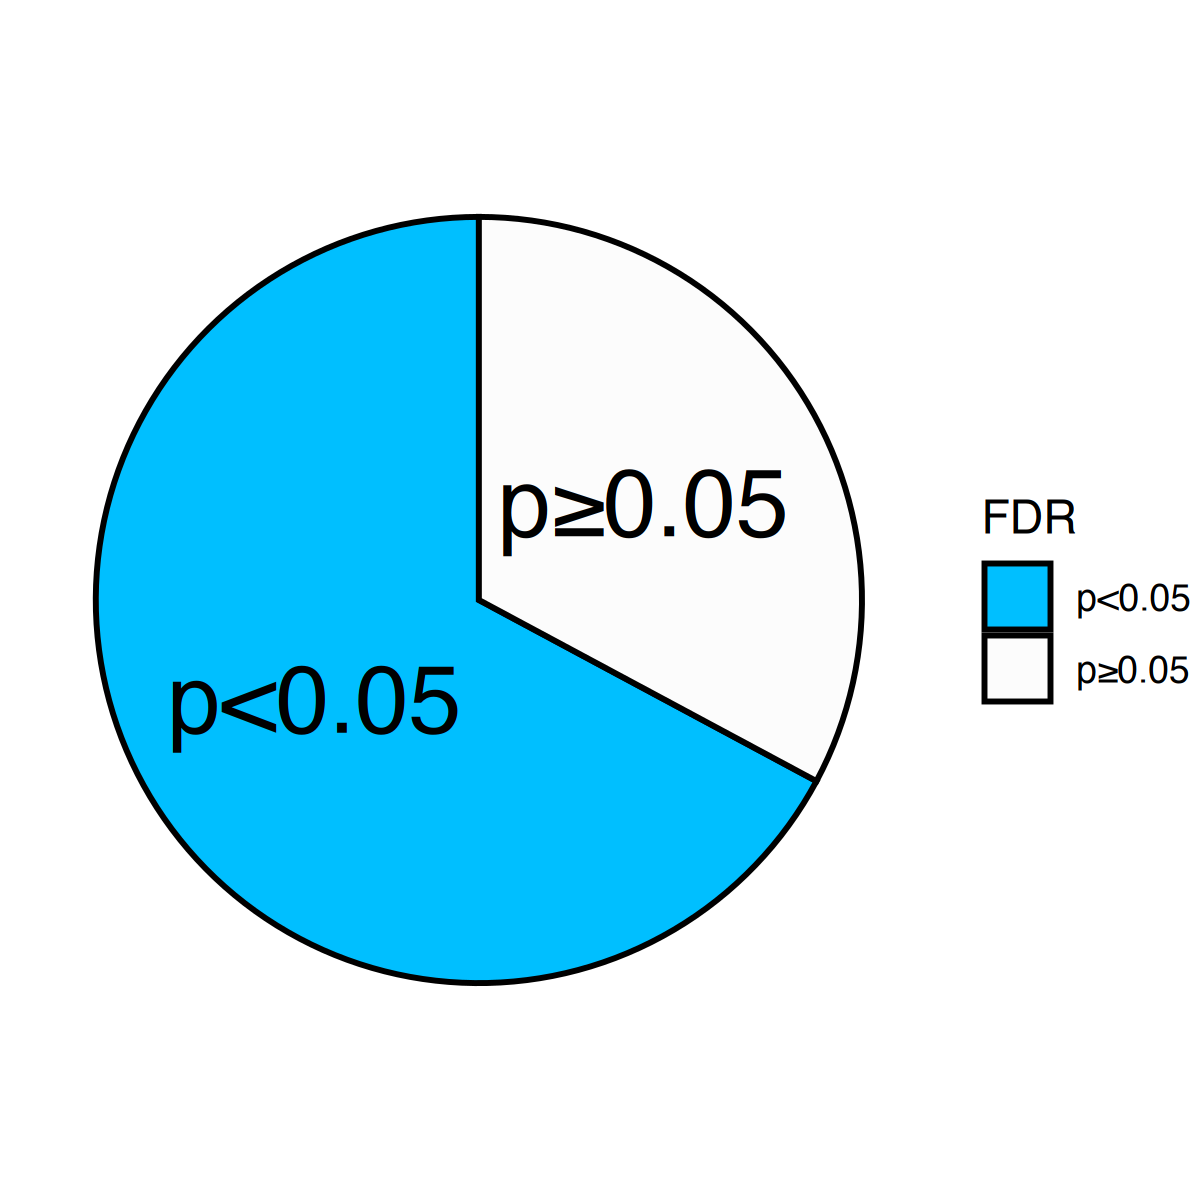

In [13]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res = 300, warn = -1)

image = ggplot(down_p_df, aes(x = "", y = percent, fill = FDR, labels = FDR)) +
  geom_col(color = "black") +
  geom_text(aes(label = FDR), color = c("black", "black"),
            position = position_stack(vjust = 0.5),size = 8,
            show.legend = FALSE) +
  guides(fill = NULL, labels = NULL) +
  scale_fill_manual(values = c("deepskyblue", "gray99")) +
  coord_polar(theta = "y") + theme_void()

ggsave(file="outputs/figures/figure1e_downsignature_inset.svg", plot=image, width=4, height=4, dpi = 600)

image

options(warn = 0)

It appears 332 out of 1,011 genes in the Down-Signature had an adjusted p-value > 0.05 (32.8% of the gene set).

We also note that many of the genes in both signatures exhibited rather small log2-fold changes as well:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


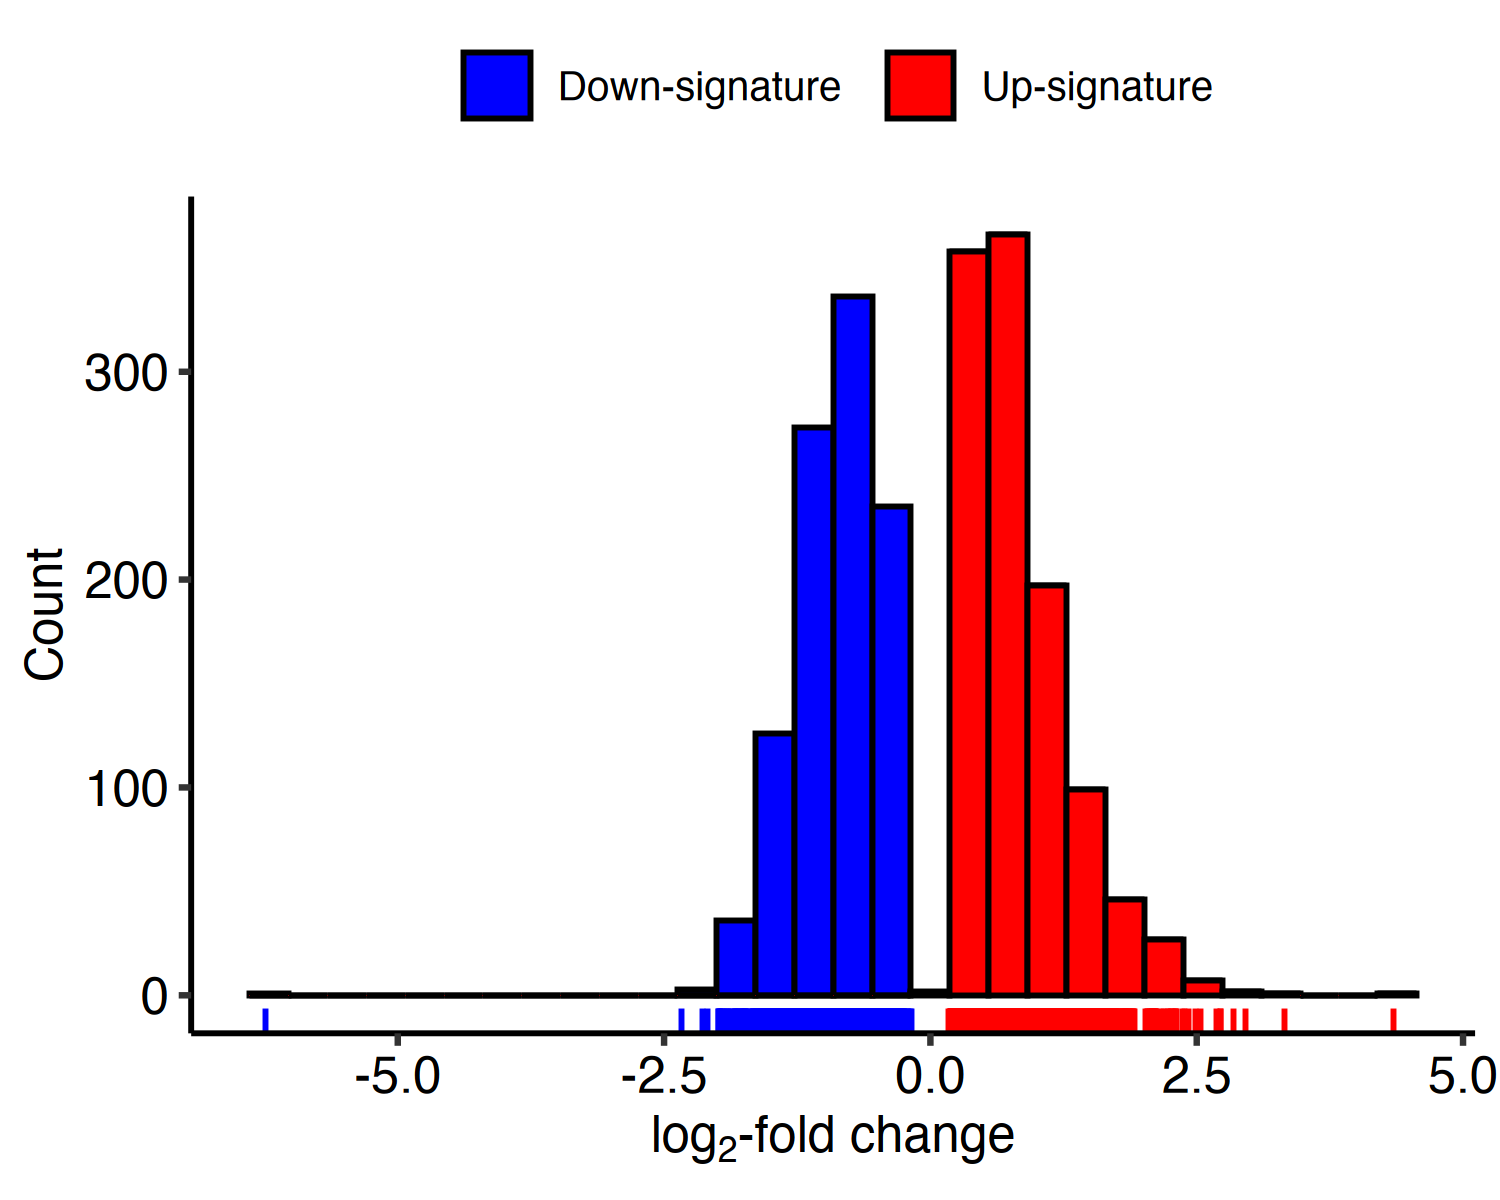

In [14]:
options(repr.plot.width=5, repr.plot.height=4, repr.plot.res = 300)

ggplot(signature %>% mutate(direction = ifelse(log2FoldChange > 0, 'Up-signature', 'Down-signature')), aes(x = log2FoldChange, fill = direction)) + 
    geom_histogram(color = 'black') + scale_fill_manual(values = c("blue", "red")) + 
    labs(x = expression(paste(log[2],"-fold change", sep = "")), y = "Count", fill = "", color = '') + 
    geom_rug(aes(color = direction)) + scale_color_manual(values = c("blue", "red")) + 
    theme_pubr() + 
    theme(plot.title=element_text(hjust = 0.5, face="bold", size = 16))

In [15]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/libopenblasp-r0.3.28.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggpubr_0.6.0  readxl_1.4.3  dplyr_1.1.4   ggplot2_3.5.1

loaded via a namespace (and not attached):
 [1] gtable_0.3.6      jsonlite_1.8.9    compiler_4.3.3    ggsignif_0.6.4   
 [5] crayon_1.5.3      tidyselect_1.2.1  IRdisplay_1.1     tidyr_1.3.1      
 [9] textshaping_0.4.0 systemfonts_1.1.0 scales_1.3.0      uuid_1.2-1       
[13] fastmap_1.2.0     IRkernel_1.3.2    R6_2.5.1          labeling_0.4.3   
[17] generics_0.1.3    Formula_1.2-5     Cairo_1.6-2       backports_1.5.0

In [16]:
version

               _                           
platform       x86_64-apple-darwin13.4.0   
arch           x86_64                      
os             darwin13.4.0                
system         x86_64, darwin13.4.0        
status                                     
major          4                           
minor          3.3                         
year           2024                        
month          02                          
day            29                          
svn rev        86002                       
language       R                           
version.string R version 4.3.3 (2024-02-29)
nickname       Angel Food Cake             